# Figure 1 - Overview of Spatial Scales

## Imports

In [21]:
# General libraries
import os
os.chdir("/home/dlhogan/GitHub/Synoptic-Sublimation/")
from pathlib import Path

# Plotting libraries
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar

# Data libraries
import numpy as np
import geopandas as gpd
import metpy.calc as mpcalc
from metpy.units import units

# Geospatial libraries
import rioxarray as rxr
import py3dep as py3d
import shapely.geometry as geom
from pynhd import NLDI, GeoConnex, WaterData
import xarray as xr
import pyproj
from shapely.geometry import LineString
from shapely.ops import transform

## Data

### Functions

In [ ]:
def get_topo(basin_geometry):
    """
    Retrieve topographic data for a given basin, including elevation, slope, and aspect.

    Parameters:
    -----------
    basin_geometry : geometry-like
        The basin geometry (e.g., a shapely polygon) defining the area of interest.
    data_path : Path
        The directory path where the topographic data will be saved (if save=True).
    save : bool, optional (default=True)
        If True, saves the retrieved topographic data as GeoTIFF files in the specified data_path.

    Returns:
    --------
    topo : dict
        A dictionary containing topographic datasets for the specified basin, including:
        - 'elevation': Digital Elevation Model (DEM).
        - 'slope_degrees': Slope in degrees.
        - 'aspect_degrees': Aspect in degrees.

    Notes:
    ------
    - The function retrieves topographic data using the `py3d.get_map` method.
    - The data is retrieved at a 30-meter resolution.
    - The source CRS is EPSG:4326, and the output CRS is EPSG:5070.
    - If `save=True`, the data is saved as GeoTIFF files in the given directory.
    """
    topo = py3d.get_map(["DEM", "Slope Degrees", "Aspect Degrees", "Hillshade Gray"], basin_geometry, 30, geo_crs=4326, crs=5070)
    return topo

### Geospatial

In [3]:
co_basin = gpd.read_file(
    "./01_data/geodata/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.geojson",
    driver="GeoJSON",
)
co_basin = co_basin[co_basin['HU_6_Name'].isin(['Upper Colorado', 'Lower Colorado'])]

In [22]:
### Colorado River scale
ucrb_boundary = gpd.read_file(Path("./01_data/geodata/Upper_Colorado_River_Basin_Boundary.json", driver='GeoJSON'))

### East River scale
basin_boundary = gpd.read_file(Path("./01_data/geodata/east_taylor_basins_4326.geojson", driver='GeoJSON'))
east_basin_bounds = basin_boundary[basin_boundary['gage']=='09112500']
upper_east_river = gpd.read_file("/home/dlhogan/GitHub/Synoptic-Sublimation/01_data/geodata/east_polygon.json", driver='GeoJSON')
# convert to 5070
upper_east_river = upper_east_river.to_crs(5070)
# Flow lines
gauge_id = "09112500"  # USGS gauge ID for East Taylor River at Almont, CO
url = "https://api.water.usgs.gov/nldi/linked-data/wqp/USGS-09112500/navigation/UM/flowlines?distance=50&trimStart=false&trimTolerance=0.1"
flow_lines = gpd.read_file(url)

# Load DEM
topo = get_topo(east_basin_bounds.geometry.values[0])

### ERA5 Reanalysis

In [16]:
# load ERA5 data
era5_ds = xr.open_dataset('/storage/dlhogan/data/ERA5_example.nc')

lat_sel_5_by_5 = slice(39.5, 38.25)
lon_sel_5_by_5 = slice(-107.5, -106.5)

lat_sel_10_by_10 = slice(40, 37.75)
lon_sel_10_by_10 = slice(-108.75,-106.5)

lat_sel_15_by_15 = slice(40.5, 37)
lon_sel_15_by_15 = slice(-110, -106.5)

era5_specific_ds = xr.open_dataset('/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_2024_v2.nc').sel(latitude=lat_sel_10_by_10, longitude=lon_sel_10_by_10)

## Figure 
Broken up into components

### Functions

In [17]:
# Start designing a grid spec figure
def turn_off_spines(ax):
    """
    Turn off the spines of a given axis.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis for which the spines
        should be turned off.
    """
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    return

### (A) Western US

In [18]:
# create ERA5 basemap of the region
lon_extent = [co_basin.total_bounds[0]-10 + 360,
              co_basin.total_bounds[2] +10 + 360]
lat_extent = [co_basin.total_bounds[3]+4,
              co_basin.total_bounds[1]-2]

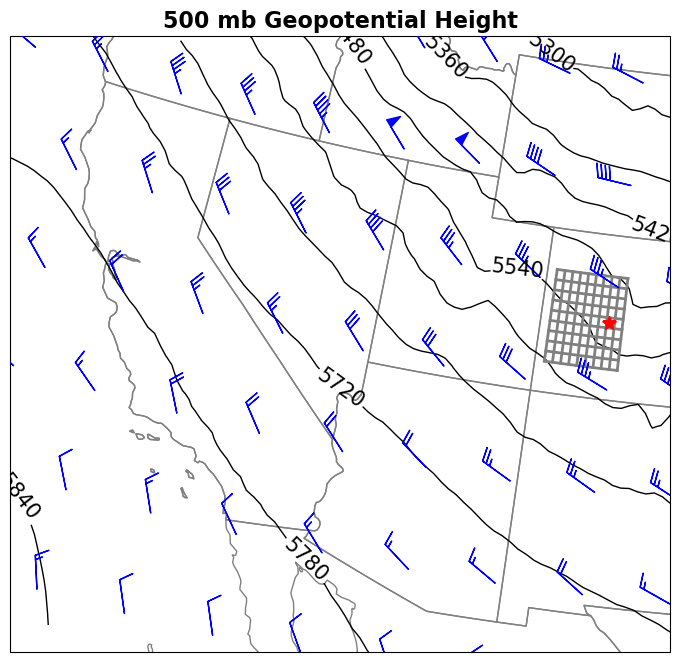

In [20]:
# create figure
fig = plt.figure(figsize=(10, 8))
ax_west_us = plt.subplot(projection=ccrs.LambertConformal(),
                      frameon=True)
# Add title to the plot
ax_west_us.set_title('500 mb Geopotential Height', fontsize=16, fontweight='bold')

# create cartopy map of US states
ax_west_us.set_extent([co_basin.total_bounds[0]-6 + 360,
                       co_basin.total_bounds[2] + 360,
                       co_basin.total_bounds[1],
                       co_basin.total_bounds[3]], crs=ccrs.PlateCarree())
ax_west_us.add_feature(cfeature.BORDERS, edgecolor='grey', linewidth=1)
ax_west_us.add_feature(cfeature.STATES,edgecolor='grey', linewidth=1)
ax_west_us.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=1)

# set background to transparent
ax_west_us.set_facecolor('none')

# Subset and convert data
z = era5_ds['z'].sel(
    longitude=slice(*lon_extent),
    latitude=slice(lat_extent[0], lat_extent[1])
).isel(valid_time=0).squeeze()

u = era5_ds['u'].sel(
    longitude=slice(*lon_extent),
    latitude=slice(lat_extent[0], lat_extent[1])
).isel(valid_time=0).squeeze()

v = era5_ds['v'].sel(
    longitude=slice(*lon_extent),
    latitude=slice(lat_extent[0], lat_extent[1])
).isel(valid_time=0).squeeze()

# Convert geopotential to height
z_height = z / 9.81 * units.meter  # now has units

# Create meshgrid
lon2d, lat2d = np.meshgrid(z.longitude, z.latitude)

# Subsample for barbs
skip = (slice(None, None, 10), slice(None, None, 10))

### Geopotential Height Contours ###
# plot contour lines for geopotential height
contours = ax_west_us.contour(
    lon2d, lat2d, z_height.values,
    levels=np.arange(5000, 6000, 60),
    colors='black',
    linewidths=1,
    transform=ccrs.PlateCarree()
)
ax_west_us.clabel(contours, inline=True, fontsize=15)

# # plot filled contours for geopotential height
# filled_contours = ax_west_us.contourf(
#     lon2d, lat2d, z_height.values,
#     levels=np.arange(5000, 6000, 60),
#     cmap='coolwarm',
#     alpha=0.5,
#     transform=ccrs.PlateCarree()
# )

# ### Colorbar ###
# # Add colorbar for filled contours
# cbar = plt.colorbar(filled_contours, ax=ax_west_us, orientation='vertical', pad=0.05)
# cbar.set_label('Geopotential Height (m)', fontsize=14, fontweight='bold')
# # Increase size of ticks and labels to 14
# cbar.ax.tick_params(labelsize=14)

### Wind Barbs ###
ax_west_us.barbs(
    lon2d[skip], lat2d[skip],
    u.values[skip], v.values[skip],
    length=7,
    transform=ccrs.PlateCarree(),
    zorder=3,
    barbcolor='blue'
)

### Meshgrid for ERA5 grid lines ###
# Extract lat/lon values
lats = era5_specific_ds.latitude.values
lons = era5_specific_ds.longitude.values

# Create a 2D meshgrid of lon/lat for plotting
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot horizontal lines (constant latitude)
for lat in lats:
    ax_west_us.plot(lons, [lat] * len(lons), color='gray', linewidth=2, transform=ccrs.PlateCarree())

# Plot vertical lines (constant longitude)
for lon in lons:
    ax_west_us.plot([lon] * len(lats), lats, color='gray', linewidth=2, transform=ccrs.PlateCarree())

# Add a star for the center of the east river boundary
center = east_basin_bounds.geometry.values[0].centroid
ax_west_us.plot(center.x, center.y, marker='*', color='red', markersize=10, transform=ccrs.PlateCarree(), zorder=3)


### (B) East River basin

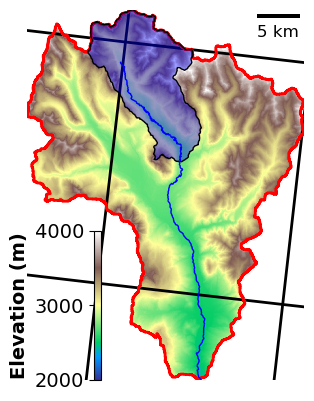

In [23]:
fig, ax = plt.subplots()
turn_off_spines(ax)
# add dem to east dem
im0 = topo['hillshade_gray'].where(topo['elevation']>0).squeeze().plot(ax=ax, 
                                                                       cmap='gray', 
                                                                       vmin=0, 
                                                                       vmax=255,
                                                                       # turn off colorbar
                                                                       add_colorbar=False)
im1 = topo['elevation'].where(topo['elevation']>0).squeeze().plot(ax=ax, 
                                                                  cmap='terrain', 
                                                                  vmin=2000, 
                                                                  vmax=4000,
                                                                  add_colorbar=False,)
# add red border around the basin
east_basin_bounds.to_crs(5070).boundary.plot(ax=ax, 
                                  color='red', 
                                  linewidth=2, 
                                  zorder=2)
# add upper east river basin
upper_east_river.plot(ax=ax, 
                      color='blue',
                      alpha=0.4, 
                      zorder=2)
# add the boundary
upper_east_river.boundary.plot(ax=ax, 
                                  color='black', 
                                  linewidth=1, 
                                  zorder=2)
# remove x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('', fontsize=16, fontweight='bold')

flow_lines.to_crs(5070).plot(ax=ax,
                             color='blue', 
                             linewidth=1, 
                             zorder=3)

# add colorbar in top left corner half the length of the figure
cbar = plt.colorbar(im1, 
                    ax=ax, 
                    # set limits to 2500 to 4000
                    orientation='vertical', 
                    location='left',
                    fraction=0.015,
                    shrink=1.2,
                    anchor=(0.2,0.0),
                    pad=-0.15)
# cbar.ax.set_title('Elevation (m)',
#                fontsize=14, 
#                fontweight='bold',
#                ha='right',)
# set the label
cbar.set_label('Elevation (m)',
               fontsize=14, 
               fontweight='bold',
               ha='center',)
# increase size of ticks and labels to 14
cbar.ax.tick_params(labelsize=14)

# add scale bar
scale3 = ScaleBar(
    dx=1,
    location='upper right',
    # label="Scale 3",
    font_properties={
        # "family": "serif",
        "size": "large",
    },  # For more information, see the cell below
    scale_formatter=lambda value, unit: f"{value} {unit}",
)
ax.add_artist(scale3,
)


# 1. Extract lat/lon from ERA5
lats = era5_specific_ds.latitude.values
lons = era5_specific_ds.longitude.values
lons = np.where(lons > 180, lons - 360, lons)  # convert 0–360 to -180–180

# 2. Create pyproj transformer from WGS84 to EPSG:5070
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True).transform

# 3. Plot lat lines (horizontal grid lines)
for i, lat in enumerate(lats):
    line = LineString(zip(lons, [lat] * len(lons)))
    line_proj = transform(project, line)
    x, y = line_proj.xy
    ax.plot(x, y, color='black', linewidth=2, zorder=1)

# 4. Plot lon lines (vertical grid lines)
for j, lon in enumerate(lons):
    line = LineString(zip([lon] * len(lats), lats))
    line_proj = transform(project, line)
    x, y = line_proj.xy
    ax.plot(x, y, color='black', linewidth=2, zorder=1)


## Appendix

### UCRB-wide region

In [ ]:
# add ucrb boundary and convert to lcc projection 
# plot the UCRB boundary
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# create cartopy map of US states
ax.set_extent([co_basin.total_bounds[0]-6,
                       co_basin.total_bounds[2],
                       co_basin.total_bounds[1],
                       co_basin.total_bounds[3]], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='grey', linewidth=0.5)
ax.add_feature(cfeature.STATES,edgecolor='grey', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.5)

# label the Western US
# ax.set_title('Western US', fontsize=16, fontweight='bold')
# add a star for the center of the east river boundary
center = east_basin_bounds.geometry.values[0].centroid
ax.plot(center.x, center.y, marker='*', color='red', markersize=10, transform=ccrs.PlateCarree(), zorder=3)

# plot the CRB boundary
co_basin.plot(ax=ax, color='blue', linewidth=1.5, zorder=2, transform=ccrs.PlateCarree(), alpha=0.3)
# annotate the CRB boundary
ax.text(co_basin.dissolve().centroid.values[0].x-1, 
        co_basin.dissolve().centroid.values[0].y, 
        'CRB', 
        fontsize=14, 
        fontweight='bold', 
        transform=ccrs.PlateCarree(), 
        zorder=4)

### Grid-spec figure creation

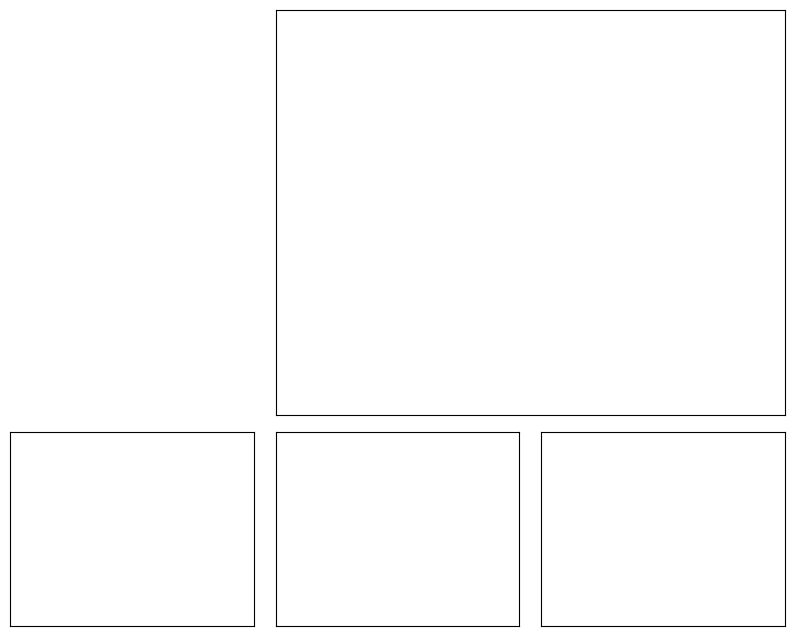

In [ ]:

# Create a grid spec figure
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 6, width_ratios=[1, 1, 1, 1, 1, 1])

ax_valley = plt.subplot(gs[0:4, 2:])
ax_avery = plt.subplot(gs[4:6, 0:2])
ax_gothic = plt.subplot(gs[4:6, 2:4])
ax_kp = plt.subplot(gs[4:6, 4:6])

ax_west_us = plt.subplot(gs[2:4, 0:2], projection=ccrs.LambertConformal(),
                      frameon=False)
ax_east_dem = plt.subplot(gs[0:3, 1:3], 
                        frameon=False)

# make the background transparent
ax_east_dem.set_facecolor('none')
# turn off spines
turn_off_spines(ax_east_dem)

# turn off labels 
ax_valley.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax_gothic.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax_avery.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax_kp.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

/tmp/ipykernel_14608/2584124648.py:68: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax_west_us.text(co_basin.dissolve().centroid.values[0].x-1, co_basin.dissolve().centroid.values[0].y, 'CRB', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)
/tmp/ipykernel_14608/2584124648.py:68: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax_west_us.text(co_basin.dissolve().centroid.values[0].x-1, co_basin.dissolve().centroid.values[0].y, 'CRB', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)


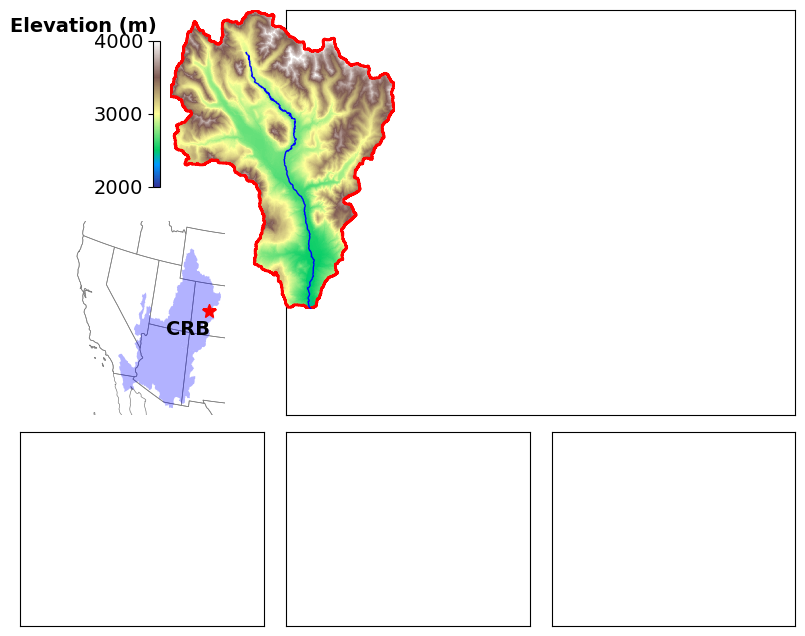

<Figure size 640x480 with 0 Axes>

In [ ]:
# add dem to east dem
im0 = topo['hillshade_gray'].where(topo['elevation']>0).squeeze().plot(ax=ax_east_dem, 
                                                                       cmap='gray', 
                                                                       vmin=0, 
                                                                       vmax=255,
                                                                       # turn off colorbar
                                                                       add_colorbar=False)
im1 = topo['elevation'].where(topo['elevation']>0).squeeze().plot(ax=ax_east_dem, 
                                                                  cmap='terrain', 
                                                                  vmin=2000, 
                                                                  vmax=4000,
                                                                  add_colorbar=False,)
# add red border around the basin
east_basin_bounds.to_crs(5070).boundary.plot(ax=ax_east_dem, 
                                  color='red', 
                                  linewidth=2, 
                                  zorder=2)
# add scale bar 


# remove x and y labels
ax_east_dem.set_xlabel('')
ax_east_dem.set_ylabel('')
ax_east_dem.set_title('', fontsize=16, fontweight='bold')

flow_lines.to_crs(5070).plot(ax=ax_east_dem,
                             color='blue', 
                             linewidth=1, 
                             zorder=3)
# add colorbar in top left corner half the length of the figure
cbar = plt.colorbar(im1, 
                    ax=ax_east_dem, 
                    # set limits to 2500 to 4000
                    orientation='vertical', 
                    location='left',
                    fraction=0.03,
                    anchor=(0,0.8),
                    pad=0.04)
cbar.ax.set_title('Elevation (m)',
               fontsize=14, 
               fontweight='bold',
               ha='right',)
# increase size of ticks and labels to 14
cbar.ax.tick_params(labelsize=14)


# add ucrb boundary and convert to lcc projection 
# plot the UCRB boundary

# create cartopy map of US states
ax_west_us.set_extent([co_basin.total_bounds[0]-6,
                       co_basin.total_bounds[2],
                       co_basin.total_bounds[1],
                       co_basin.total_bounds[3]], crs=ccrs.PlateCarree())
ax_west_us.add_feature(cfeature.BORDERS, edgecolor='grey', linewidth=0.5)
ax_west_us.add_feature(cfeature.STATES,edgecolor='grey', linewidth=0.5)
ax_west_us.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.5)

# label the Western US
# ax_west_us.set_title('Western US', fontsize=16, fontweight='bold')
# add a star for the center of the east river boundary
center = east_basin_bounds.geometry.values[0].centroid
ax_west_us.plot(center.x, center.y, marker='*', color='red', markersize=10, transform=ccrs.PlateCarree(), zorder=3)

# plot the CRB boundary
co_basin.plot(ax=ax_west_us, color='blue', linewidth=1.5, zorder=2, transform=ccrs.PlateCarree(), alpha=0.3)
# annotate the CRB boundary
ax_west_us.text(co_basin.dissolve().centroid.values[0].x-1, co_basin.dissolve().centroid.values[0].y, 'CRB', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)

fig